# LOCA Interploation Test

In [204]:
import pickle
import math
from scipy import spatial
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
import torch 
import torchvision
from torch.autograd import grad
from torch import nn, optim

In [207]:
#Data Generation Parameters
samples = 2000
size = 200
sig_sq = 0.0001
#Training Parameters
batch_cloud_num = 200
val_cloud_num = 200
epochs = 300
learning_rate = 1e-3 #1e-4 for finetuning
val_epochs = 5 #Period of epochs after which the model is validated. 
#Network Parameters
input_dim = 2
latent_dim = 2
hidden_neurons = 50
gain_factor = 0.6

## Data generation and transformation

In [137]:
def deformation(x):
    #This function transforms the data which the encoder of the LOCA has to invert and the decoder has to reapply.
    y = np.empty((2))
    y[0] = x[0] + x[1]**3
    y[1] = x[1] - x[0]**3
    return y

def data_prep(cent, clouds):
    for i in range(points.shape[0]):
        cent[i, ::] =  deformation(cent[i, ::])
        cent[i, 0 ] = cent[i, 0] - 1
        for j in range(points.shape[1]):
            clouds[i, j, ::] = deformation(clouds[i, j, ::])
            clouds[i, j, 0 ] = clouds[i, j, 0] - 1    
    return cent, clouds

def plot(string, *args):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set(xlabel='X', ylabel='Y',
          title=string)
    for arg in args:
        if len(arg.shape) == 3:
            ax.scatter(arg[::,::, 0], arg[::, ::, 1], c='b', alpha=0.006)
        else:
            ax.scatter(arg[::, 0], arg[::, 1], c='k', alpha=1, s = 4)

In [138]:
def samples_train(size= size, samples=samples, sig_sq=sig_sq):
    #This function generates the data, in the form of clouds around a given number of anchor points in a hollow square. 
    #This data will be used as the training data.
    center = np.empty(shape = (samples, 2))
    points = np.empty(shape = (samples, size, 2))
    
    for i in range(samples):
        side_list = ['rigth','top','left','bottom']
        side = random.choice(side_list)
        if side == 'rigth':
            center[i, ::] = np.random.uniform(low=[0, 0.1], high=[0.1, 1], size=(2))
        if side == 'top':
            center[i, ::] = np.random.uniform(low=[0.1, 0.9], high=[1, 1], size=(2))
        if side == 'left':
            center[i, ::] = np.random.uniform(low=[0.9, 0.9], high=[1, 0], size=(2))
        if side == 'bottom':
            center[i, ::] = np.random.uniform(low=[0.9, 0.1], high=[0, 0], size=(2))
            
        pts = np.random.multivariate_normal(center[i, ::], [[sig_sq,0],[0,sig_sq]], size=size)
       
        points[i, ::, 0] = pts[::, 0] 
        points[i, ::, 1] = pts[::, 1] 
       
    return points, center

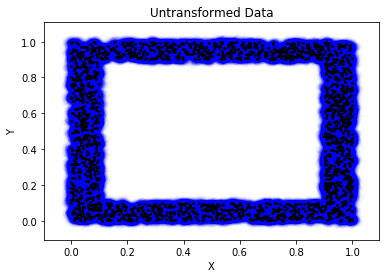

In [139]:
#Calling the data generation function and visualizing the results.
points, center = samples_train(size= size, samples=samples, sig_sq=sig_sq)
plot("Untransformed Data", points, center)

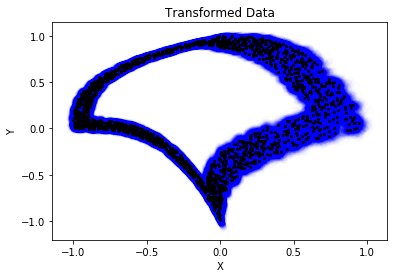

In [140]:
#Applying the transformation and rescaling the data to create the final training data.
tran_cent, tran_sq = data_prep(center, points)
plot("Transformed Data", tran_sq, tran_cent)

### Defining the whitening loss

In [7]:
def cov(m, rowvar=False):
    #This function calculates the covariance matrix which is needed in the loss function of the encoder.
    if not rowvar and m.size(0) != 1:
        m = m.t()
    fact = 1.0 / (m.size(1) - 1)
    m_sub_mean = m - torch.mean(m, dim=1, keepdim=True)
    mt = m_sub_mean.t()  # if complex: mt = m.t().conj()
    m_mul = m_sub_mean.matmul(mt)
    f_m_mul = fact * m_mul
    cov_mat = f_m_mul.squeeze()
    return cov_mat.cuda()

In [8]:
def loss_whiten(outputs_en):
    #This function calculates the whitening loss for the encoder.
    L_un = 0
    clouds = torch.reshape(outputs_en, (batch_cloud_num, -1, latent_dim))
    #interate through all the other points.
    for d in range(batch_cloud_num):
        #calculate the covariance
        C = cov(clouds[d, ::, ::])
        #calculate the summed loss
        L = ((torch.norm(1/sig_sq*C-torch.eye(latent_dim).to(device)))**2)
        L_un = L_un + L

    #norm the loss by the batch size
    L_w = L_un/batch_cloud_num
    return L_w
#The reconstruction loss for the decoder
loss_recon = nn.MSELoss()

### Model

In [9]:
#The Data is reshaped and the data loaders are created. 
batch_size = batch_cloud_num*tran_sq.shape[1]
valdation = tran_sq[:val_cloud_num, ::, ::]
training = tran_sq[val_cloud_num:, ::, ::]

val_dataset = np.reshape(valdation, (valdation.shape[0]*valdation.shape[1], valdation.shape[2]))
train_dataset = np.reshape(training, (training.shape[0]*training.shape[1], training.shape[2]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

input_shape = train_dataset.shape[1]

In [10]:
#The LOCA Network is created
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_input_layer = nn.Linear(
            in_features=input_dim, out_features= hidden_neurons)
        
        self.encoder_hidden_layer1 = nn.Linear(
            in_features= hidden_neurons, out_features= hidden_neurons)
        
        self.encoder_hidden_layer2 = nn.Linear(
            in_features= hidden_neurons+input_dim, out_features= latent_dim)
        
        self.encoder_hidden_layer3 = nn.Linear(
            in_features= latent_dim, out_features= latent_dim)
        
        self.encoder_output_layer = nn.Linear(
            in_features= latent_dim, out_features= latent_dim)
        
        self.decoder_input_layer = nn.Linear(
            in_features= latent_dim, out_features= latent_dim)
        
        self.decoder_hidden_layer1 = nn.Linear(
            in_features= latent_dim, out_features= hidden_neurons)
        
        self.decoder_hidden_layer2 = nn.Linear(
            in_features= hidden_neurons, out_features= hidden_neurons)
        
        self.decoder_hidden_layer3 = nn.Linear(
            in_features= hidden_neurons, out_features= input_shape)    
        
        self.decoder_output_layer = nn.Linear(
            in_features= input_shape, out_features=input_shape)
        
        self.tanh = nn.Tanh()
        
    def forward_encoder(self, features):
        n_e1 = self.encoder_input_layer(features)
        a_e1 = self.tanh(n_e1)
        
        n_e2 = self.encoder_hidden_layer1(a_e1)
        a_e2 = self.tanh(n_e2)
        
        n_e3 = self.encoder_hidden_layer2(torch.cat((a_e2, features), -1))
        a_e3 = self.tanh(n_e3)
        
        n_e4 = self.encoder_hidden_layer3(a_e3)
        
        outputs_en = self.encoder_output_layer(n_e4)
        
        return outputs_en
    
    def forward_decoder(self, outputs_en):
        n_d1 = self.decoder_input_layer(outputs_en)
        a_d1 = self.tanh(n_d1)
        
        n_d2 = self.decoder_hidden_layer1(a_d1)
        a_d2 = self.tanh(n_d2)
        
        n_d3 = self.decoder_hidden_layer2(a_d2)
        a_d3 = self.tanh(n_d3)
        
        n_d4 = self.decoder_hidden_layer3(a_d3)
        
        reconstructed = self.decoder_output_layer(n_d4)
        
        return reconstructed

In [11]:
# Create the necessary objects for the neural network.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load it to the specified device, either gpu or cpu
model_ae = AE(input_shape=input_shape).to(device)
# create an optimizer object
optimizer_ae = optim.Adam(model_ae.parameters(), lr=learning_rate)

In [ ]:
#The weigths are initialized based on the xavier scheme, 
#which is preferable to the He scheme that is the default in Pytorch that is optimized for the RELU function.
torch.nn.init.xavier_uniform_(model_ae.encoder_input_layer.weight, gain=gain_factor*nn.init.calculate_gain('tanh'))
torch.nn.init.xavier_uniform_(model_ae.encoder_hidden_layer1.weight, gain=gain_factor*nn.init.calculate_gain('tanh'))
torch.nn.init.xavier_uniform_(model_ae.encoder_hidden_layer2.weight, gain=gain_factor*nn.init.calculate_gain('tanh'))
torch.nn.init.xavier_uniform_(model_ae.encoder_hidden_layer3.weight, gain=gain_factor*nn.init.calculate_gain('tanh'))
torch.nn.init.xavier_uniform_(model_ae.encoder_output_layer.weight, gain=gain_factor*nn.init.calculate_gain('tanh'))

torch.nn.init.xavier_uniform_(model_ae.decoder_input_layer.weight, gain=nn.init.calculate_gain('tanh'))
torch.nn.init.xavier_uniform_(model_ae.decoder_hidden_layer1.weight, gain=nn.init.calculate_gain('tanh'))
torch.nn.init.xavier_uniform_(model_ae.decoder_hidden_layer2.weight, gain=nn.init.calculate_gain('tanh'))
torch.nn.init.xavier_uniform_(model_ae.decoder_hidden_layer3.weight, gain=nn.init.calculate_gain('tanh'))
torch.nn.init.xavier_uniform_(model_ae.decoder_output_layer.weight, gain=nn.init.calculate_gain('tanh'))

In [209]:
#load a pretrained model if you want to. It was trained with a learning rate of 1e-3, 1e-4 and 1e-5 for 500 epochs each
best_epoch = np.argmin(val_total)
model_ae.load_state_dict(torch.load("./pre_trained"))
model_ae.eval()

AE(
  (encoder_input_layer): Linear(in_features=2, out_features=50, bias=True)
  (encoder_hidden_layer1): Linear(in_features=50, out_features=50, bias=True)
  (encoder_hidden_layer2): Linear(in_features=52, out_features=2, bias=True)
  (encoder_hidden_layer3): Linear(in_features=2, out_features=2, bias=True)
  (encoder_output_layer): Linear(in_features=2, out_features=2, bias=True)
  (decoder_input_layer): Linear(in_features=2, out_features=2, bias=True)
  (decoder_hidden_layer1): Linear(in_features=2, out_features=50, bias=True)
  (decoder_hidden_layer2): Linear(in_features=50, out_features=50, bias=True)
  (decoder_hidden_layer3): Linear(in_features=50, out_features=2, bias=True)
  (decoder_output_layer): Linear(in_features=2, out_features=2, bias=True)
  (tanh): Tanh()
)

In [ ]:
#This is the training loop of the network.
#Create lists of training metrics
epoch_list = []
val_whiten = []
val_recon = []
val_total = []

for epoch in range(epochs):
    train_loss_en = 0
    train_loss_de = 0
    loss = 0
    if epoch % 2 == 0:
        for batch_features in train_loader:
            # Encoder training
            # load it to the active device
            batch_features = batch_features.to(device)
            optimizer_ae.zero_grad()
            # compute reconstructions
            outputs_en = model_ae.forward_encoder(batch_features.float())
            # compute training reconstruction loss
            train_loss_en = loss_whiten(outputs_en)
            
            # compute accumulated gradients
            train_loss_en.backward()

            # perform parameter update based on current gradients
            optimizer_ae.step()

            # add the mini-batch training loss to epoch loss
            loss += train_loss_en.item()
    else:
        for batch_features in train_loader:
            # Encoder training
            # load it to the active device
            batch_features = batch_features.to(device)
            optimizer_ae.zero_grad()
            
            # freeze the encoder parameters during decoder training
            for param in model_ae.encoder_input_layer.parameters():
                param.requires_grad = False
            for param in model_ae.encoder_hidden_layer1.parameters():
                param.requires_grad = False
            for param in model_ae.encoder_hidden_layer2.parameters():
                param.requires_grad = False
            for param in model_ae.encoder_hidden_layer3.parameters():
                param.requires_grad = False
            for param in model_ae.encoder_output_layer.parameters():
                param.requires_grad = False
            # compute reconstructions
            outputs_en = model_ae.forward_encoder(batch_features.float())
            outputs_de = model_ae.forward_decoder(outputs_en.float())
            # compute training reconstruction loss
            train_loss_de = loss_recon(outputs_de.double(), batch_features.double())
            # compute accumulated gradients
            train_loss_de.backward()

            # perform parameter update based on current gradients
            optimizer_ae.step()
            
            # unfreeze the encoder parameters
            for param in model_ae.encoder_input_layer.parameters():
                param.requires_grad = True
            for param in model_ae.encoder_hidden_layer1.parameters():
                param.requires_grad = True
            for param in model_ae.encoder_hidden_layer2.parameters():
                param.requires_grad = True
            for param in model_ae.encoder_hidden_layer3.parameters():
                param.requires_grad = True
            for param in model_ae.encoder_output_layer.parameters():
                param.requires_grad = True
            # add the mini-batch training loss to epoch loss
            loss += train_loss_de.item()
    if (epoch % val_epochs) == 0 and epoch > 0:
        #Validate the models performance
        val_loss_en = 0 
        val_loss_de = 0

        for batch_val in test_loader:
            batch_val = batch_val.to(device)
            outputs_en_val = model_ae.forward_encoder(batch_val.float())
            outputs_de_val = model_ae.forward_decoder(outputs_en_val.float())
            val_loss_en = loss_whiten(outputs_en_val)
            val_loss_de = loss_recon(outputs_de_val.double(), batch_val.double())

        val_loss_en = val_loss_en.cpu().detach().numpy()/len(test_loader)
        val_loss_de = val_loss_de.cpu().detach().numpy()/len(test_loader)

        val_whiten.append(val_loss_en)
        val_recon.append(val_loss_de)
        val_total.append(val_loss_en + val_loss_de)
        epoch_list.append(epoch)

        fig, ax = plt.subplots()
        ax.plot(epoch_list, val_whiten, 'g', label = "Whitening Loss")
        ax.plot(epoch_list, val_recon, 'r', label = "Reconstruction Loss")
        ax.set(xlabel='Epochs', ylabel='Loss',
              title='Loss over time')
        ax.legend()
        ax.grid()
        plt.show()

        print("Validation: epoch : {}/{}, loss_whiten = {:.4f}, loss_recon = {:.4f}".format(epoch, epochs, val_loss_en, val_loss_de))
        torch.save(model_ae.state_dict(), "./Model_Parameters_Epoch"+str(epoch))
        
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.4f}, loss_whiten = {:.4f}, loss_recon = {:.4f}".format(epoch + 1, epochs, loss, train_loss_en, train_loss_de))

In [201]:
best_epoch = np.argmin(val_total)
model_ae.load_state_dict(torch.load("./Model_Parameters_Epoch"+str(best_epoch*val_epochs)))
model_ae.eval()

AE(
  (encoder_input_layer): Linear(in_features=2, out_features=50, bias=True)
  (encoder_hidden_layer1): Linear(in_features=50, out_features=50, bias=True)
  (encoder_hidden_layer2): Linear(in_features=52, out_features=2, bias=True)
  (encoder_hidden_layer3): Linear(in_features=2, out_features=2, bias=True)
  (encoder_output_layer): Linear(in_features=2, out_features=2, bias=True)
  (decoder_input_layer): Linear(in_features=2, out_features=2, bias=True)
  (decoder_hidden_layer1): Linear(in_features=2, out_features=50, bias=True)
  (decoder_hidden_layer2): Linear(in_features=50, out_features=50, bias=True)
  (decoder_hidden_layer3): Linear(in_features=50, out_features=2, bias=True)
  (decoder_output_layer): Linear(in_features=2, out_features=2, bias=True)
  (tanh): Tanh()
)

In [192]:
def loca_forward_pass(y, decoder = False):
    y = np.reshape(y, (-1, size, input_dim))
    pred = np.empty_like(y)
    pred_loader = torch.utils.data.DataLoader(
    y.reshape(-1, input_dim), batch_size=size*batch_cloud_num, shuffle=False, pin_memory=True)
    i = 0
    for batch_features in pred_loader:
        batch_features = batch_features.to(device)
        x = model_ae.forward_encoder(batch_features.float())
        if decoder == True:
            x = model_ae.forward_decoder(x.float())
            pred_burst = torch.reshape(x, (-1, size, input_dim))
        else:
            pred_burst = torch.reshape(x, (-1, size, latent_dim))
        pred[(i*size):((i+1)*size), ::, ::] = pred_burst.cpu().detach().numpy()
        i = i + 1
    return pred

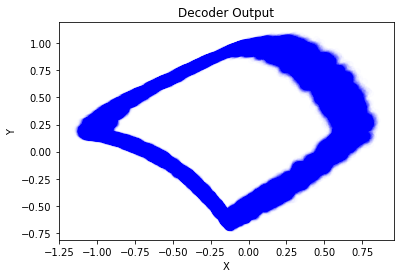

In [193]:
pred = loca_forward_pass(train_dataset, decoder = True)
#Plot the reconstructed training data set.
plot("Decoder Output", pred)

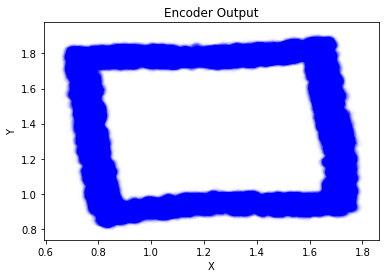

In [194]:
pred = loca_forward_pass(train_dataset, decoder = False)
plot("Encoder Output", pred)

In [210]:
def isometry_check(samples = 3000):
    points_input = np.empty(shape = (samples, 2))
    points_input_untransformed = np.empty(shape = (samples, 2))
    points_output = np.empty(shape = (samples, 2))

    for i in range(samples):
        points_input_untransformed[i, ::] = np.random.uniform(low=0, high=1, size=(2))
        points_input[i, ::] = deformation(points_input_untransformed[i, ::])
        points_input[i, 0] = points_input[i, 0] -1
        Input_1 = torch.from_numpy(points_input[i, ::].flatten()).float()
        outputs_en = model_ae.forward_encoder(Input_1.cuda())
        points_output[i, ::] = np.reshape(outputs_en.cpu().detach().numpy(), (2))

    real_distance = []
    pred_distance = []

    for d in range(samples):
        point_1 = np.random.randint(0, samples)
        point_2 = np.random.randint(0, samples)
        dist_pred = spatial.distance.euclidean(points_input_untransformed[point_1], points_input_untransformed[point_2])
        dist_real = spatial.distance.euclidean(points_output[point_1], points_output[point_2])
        real_distance.append(dist_real)
        pred_distance.append(dist_pred)
    return real_distance, pred_distance

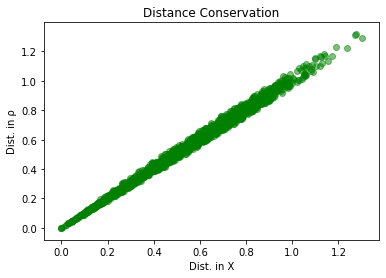

In [211]:
#Plot the results
real_distance, pred_distance = isometry_check(samples = 2000)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel("Dist. in X")
ax.set_xlabel("Dist. in ρ")
ax.set(xlabel='Dist. in X', ylabel='Dist. in ρ',
      title='Distance Conservation')
ax.scatter(real_distance, pred_distance, c='g', alpha=0.5)

### Interploation Demonstration

In [164]:
def samples_grid(size= 200, samples=2000, sig_sq=0.01, gaussian = False):
    #This function creates a grid passing throught covering areas contained in the training set as well as areas not covered.
    #I left the point at (0, 0) because it serves as a good orientation point, to see how the embedding is beeing rotated. 
    center = np.zeros(shape = (samples, 2))
    step_len = 0.8/(samples/6)
    for d in range(int(samples/6)):
        center[d, 0] = 0.1
        center[d, 1] = 0.1+step_len*d

        center[d+int(samples/6), 0] = 0.1+step_len*d
        center[d+int(samples/6), 1] = 0.9

        center[d+2*int(samples/6), 0] = 0.9
        center[d+2*int(samples/6), 1] = 0.1+step_len*d

        center[d+3*int(samples/6), 0] = 0.1+step_len*d
        center[d+3*int(samples/6), 1] = 0.1

        center[d+4*int(samples/6), 0] = 0.6
        center[d+4*int(samples/6), 1] = 0.1+step_len*d

        center[d+5*int(samples/6), 0] = 0.1+step_len*d
        center[d+5*int(samples/6), 1] = 0.6
        
    points = np.empty(shape = (samples, size, 2))
    
    for i in range(samples):
        pts = np.random.uniform([center[i, 0]-sig_sq, center[i, 1]-sig_sq], [center[i, 0]+sig_sq, center[i, 1]+sig_sq], (size, 2))
        points[i, ::, 0] = pts[::, 0] 
        points[i, ::, 1] = pts[::, 1] 
       
    return points, center

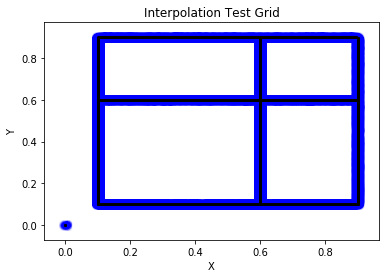

In [195]:
#Plots the grid thagt the model has to reconstruct through its encoder
points, center = samples_grid(size= 200, samples=2000, sig_sq=0.01, gaussian = False)
plot('Interpolation Test Grid', points, center)

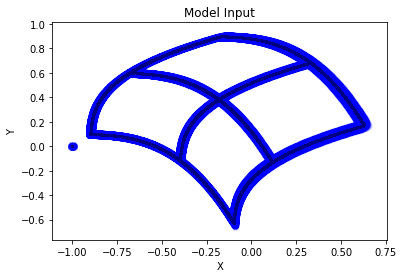

In [196]:
#Transforms the grid by the same transformationas the train se
center, points = data_prep(center, points)
plot('Model Input', center, points)

In [197]:
#Feeds the transfomed grid through the encoder
emb_grid = loca_forward_pass(points, decoder = False)

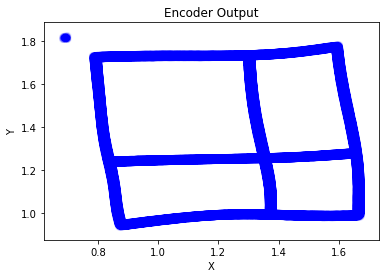

In [198]:
#Plots the encoder output
plot('Encoder Output', emb_grid)

In [199]:
#Feeds the Grid though the encoder and decoder
points = loca_forward_pass(points, decoder = True)

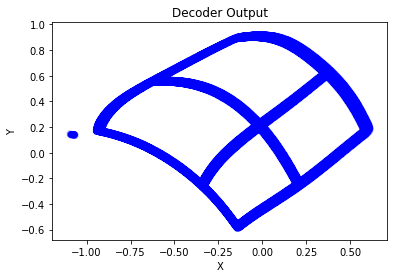

In [200]:
#Plots the decoder output.
plot('Decoder Output', points)